In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Code RAG - Reuse your already created codebase to generate more code


<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/GoogleCloudPlatform/generative-ai/tree/main/gemini/use-cases/retrieval-augmented-generation/code_rag.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Ftree%2Fmain%2Fgemini%2Fuse-cases%2Fretrieval-augmented-generation%2Fcode_rag.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/tree/main/gemini/use-cases/retrieval-augmented-generation/code_rag.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/tree/main/gemini/use-cases/retrieval-augmented-generation/code_rag.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
|Author(s) | [Keshav Kumar](https://github.com/solidate)|

# Overview

Code RAG (Retrieval-Augmented Generation) is a good technique that can help boost developer productivity. It can help by enhancing the development experience and reduce technical debt from codebases by learning patterns from already written code and suggesting reusable code snippets for the current tasks at hand.

Code RAG leverages the already indexed code to either complete or generate code based on user inputs.

The notebook uses following Google Cloud ML services and resources:
  - **Gemini:** [Gemini](https://ai.google.dev/models/gemini) is a family of generative AI models that lets developers generate content and solve problems. These models are designed and trained to handle both text and images as input.
  - **Gemini 1.0 Pro model (gemini-1.0-pro):** Designed to handle natural language tasks, multi-turn text and code chat, and code generation.
  - **Code Bison model (code-bison-32k@002):** Designed to handle code related task like code generation, unit test generation, code refactoring etc.

- **LangChain:** [LangChain](https://www.langchain.com/) is a framework designed to make integration of Large Language Models (LLM) like Gemini easier for applications.

- **Chroma DB:** [Chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma) is the open-source embedding database. Chroma makes it easy to build LLM apps by making knowledge, facts, and skills pluggable for LLMs.

- **Vertex AI Embeddings for Text:** With [textembedding-gecko](https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/text-embeddings) models we can easily create a text embedding with LLM. *textembedding-gecko@003* is the newest stable embedding model.


For more information, see the [Generative AI](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview) on Vertex AI documentation.

## Objective


This notebook utilizes the  Google Vertex AI Generative capabilities for performing RAG(Retrieval-Augmented Generation) with Code.

This notebook uses  [LangChain](https://python.langchain.com/docs/get_started/introduction.html) for operationalize workflow and uses [Chroma DB](https://docs.trychroma.com/) for persisting Vertex embeddings for the code snippets for similarity search.

[Tree Sitter](https://github.com/tree-sitter) is used for code parsing. `Tree Sitter` is a parser generator tool and an incremental parsing library. It can build a concrete syntax tree for a source file and efficiently update the syntax tree as the source file is edited.

The code repository used as an example is [Python Fire Repository](https://github.com/google/python-fire) 🔥, which is a tool for automatically generating command line interfaces (CLIs) from absolutely any Python object.
This Repository is being used as code knowledge base that is used along with Vertex AI Models like Gemini to provide code completion and code generation.


# Architecture outlining the workflow

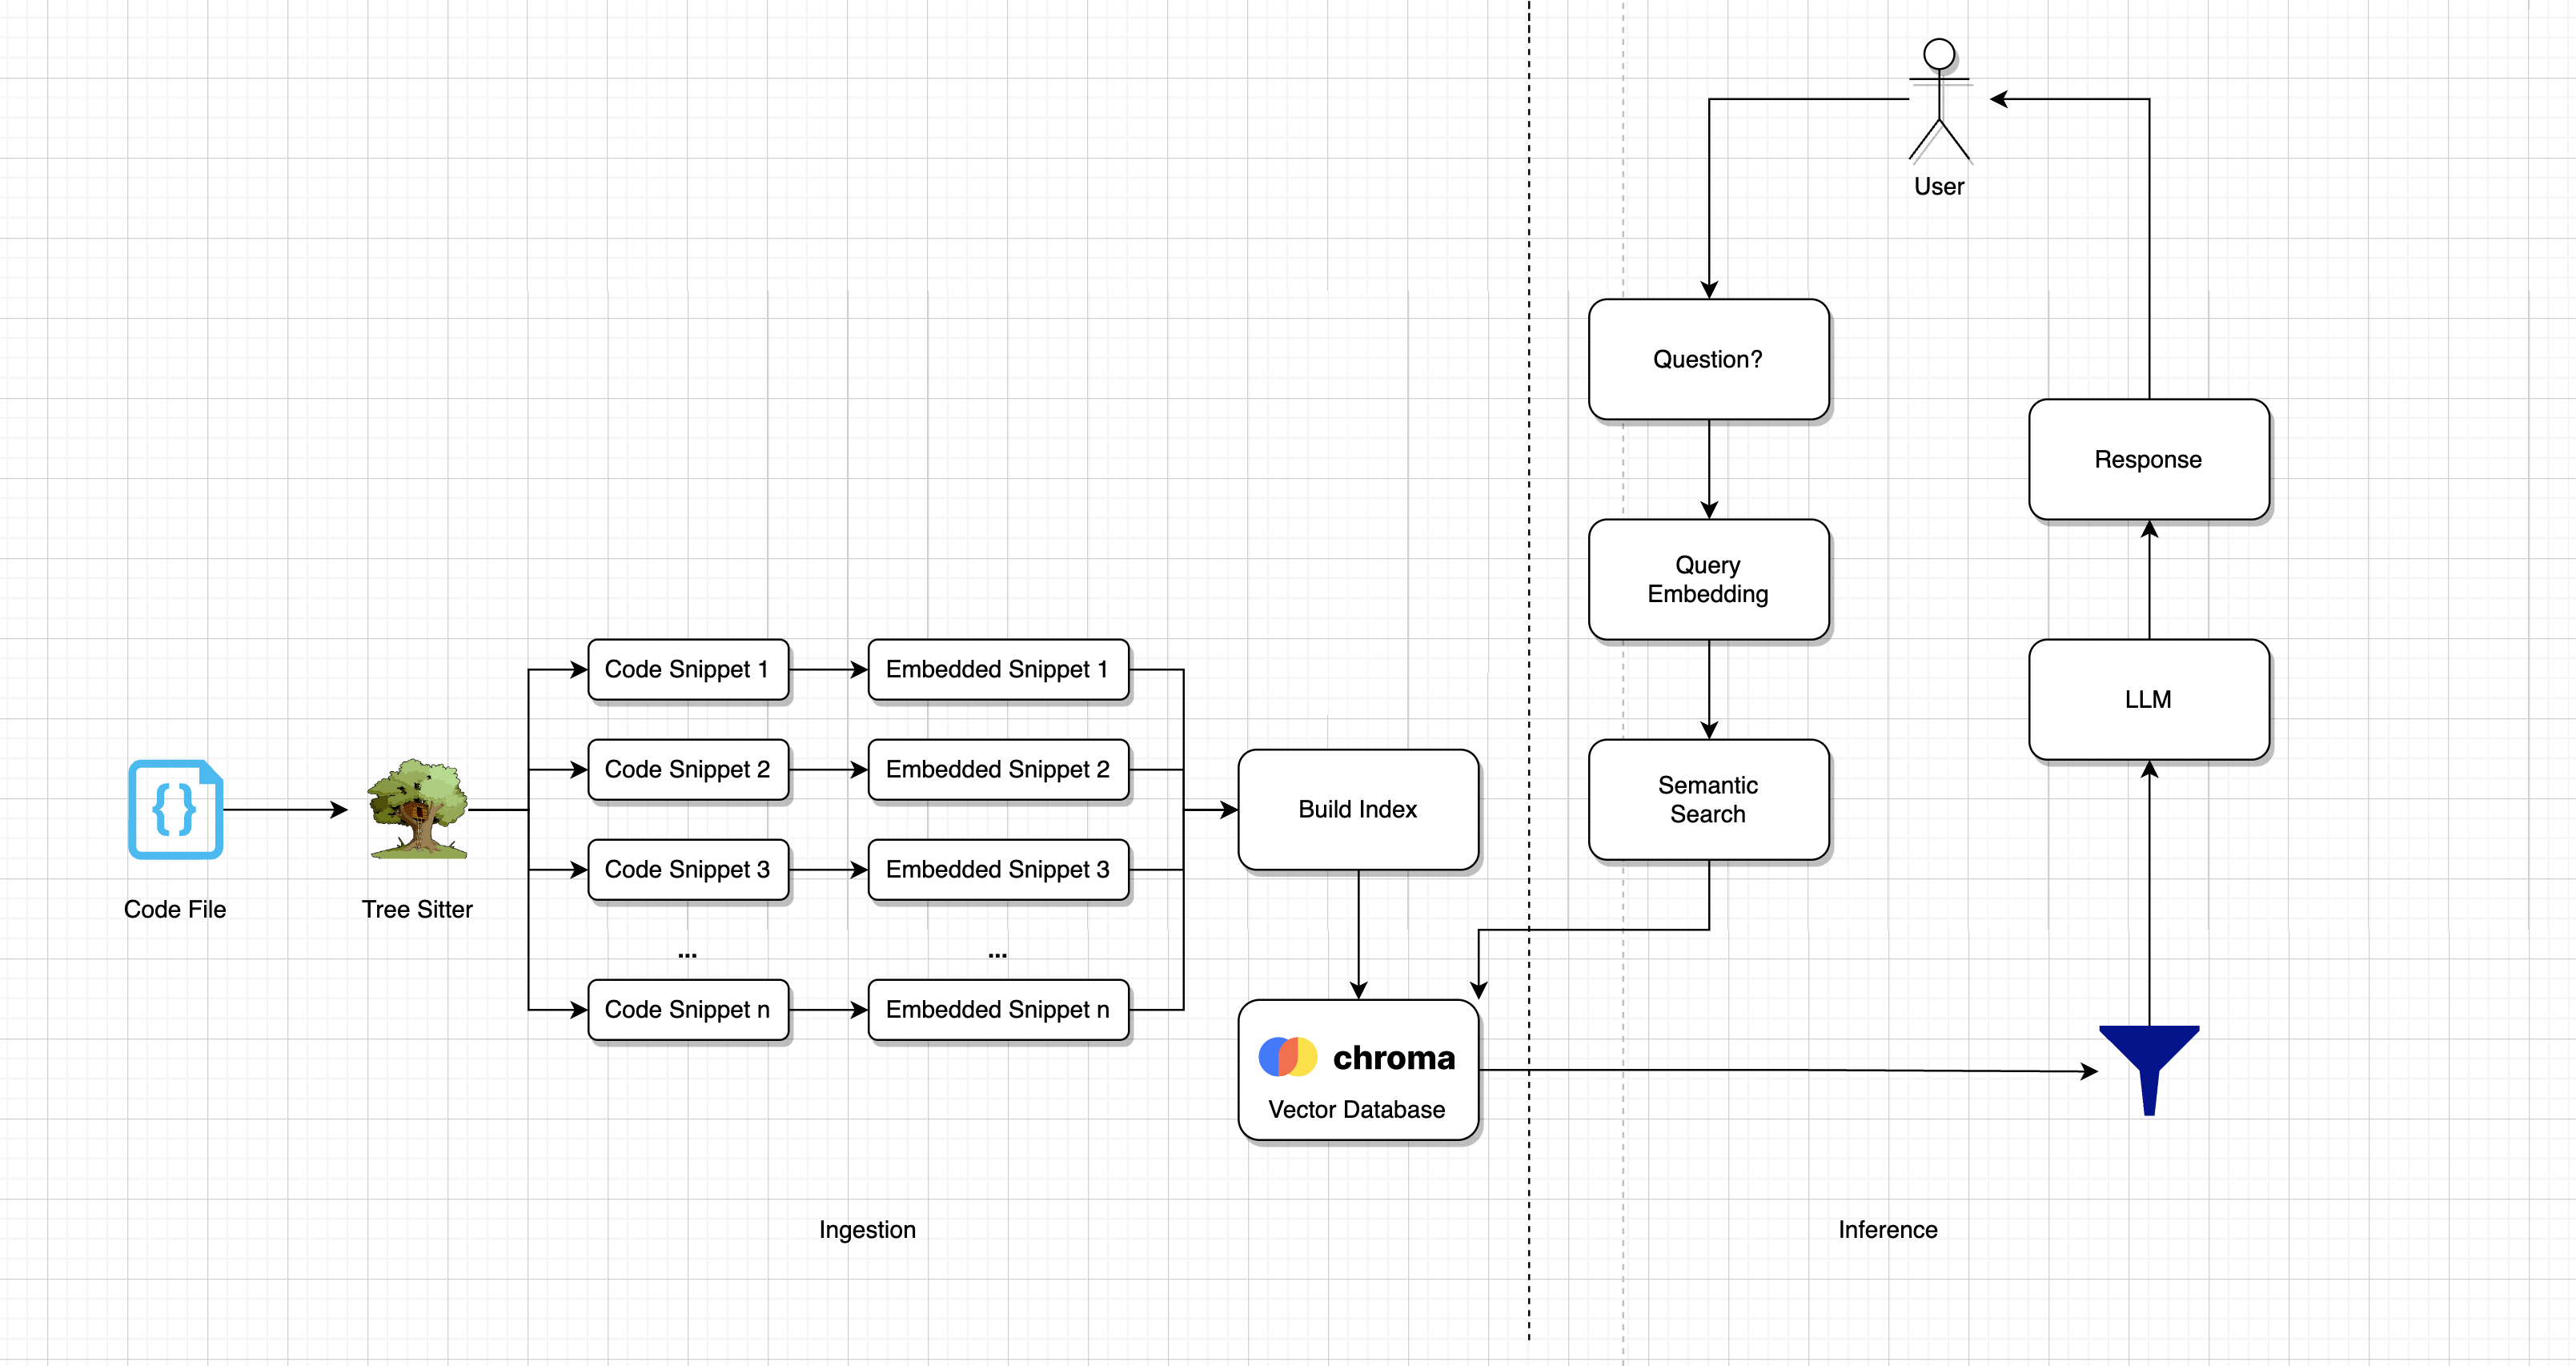

## Getting Started

### Install Vertex AI SDK and other required packages


In [ ]:
! pip3 install --upgrade --user bigframes==0.25 \
tree-sitter==0.20.1 \
loguru==0.7.2\
chromadb==0.4.22 \
google-cloud-aiplatform==1.45.0 \
langchain_google_vertexai==0.1.2 \
langchain==0.1.12 \
gradio==3.41.2 \
--quiet

### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.

In [1]:
import sys

if "google.colab" in sys.modules:
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

Authenticate your environment on Google Colab.


In [1]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

In [2]:
PROJECT_ID = "your-project-id"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

import warnings

warnings.filterwarnings("ignore")

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

## Clone the tree sitter grammar from github

A `Tree Sitter` grammar is composed of a set of rules - objects that describe how syntax nodes can be composed from other syntax nodes. There are several types of rules: symbols, strings, regexes, sequences, choices, repetitions, and a few others.

In this notebook, Python files are required to parsed and chunked into unit code snippets like classes and function definitions. The source code for `tree-sitter-python` grammar is downloaded for building the binary that can help in creating the code snippet by extracting entities from Abstract Syntax Tree of the code files. More languages can be supported as well if needed. Follow the [link](https://github.com/tree-sitter/py-tree-sitter) to add more language support.

In [ ]:
import os

tree_sitter_parent_dir_name = "tmp"  # @param {type:"string"}
tree_sitter_parent_dir = os.path.join(os.getcwd(), tree_sitter_parent_dir_name)


!git clone https://github.com/tree-sitter/tree-sitter-python.git {tree_sitter_parent_dir}/tree-sitter-python/

## Clone the Code Repository you want to index and use with RAG

In this example, to demonstrate the functionality of RAG with code, a code repository is downloaded locally for indexing. [Python Fire ](https://github.com/google/python-fire) 🔥 is being used for this demo, which is a code repository for automatically generating command line interfaces (CLIs) from absolutely any Python object.

In [ ]:
github_repository_clone_url = (
    "https://github.com/google/python-fire.git"  # @param {type:"string"}
)

!git clone {github_repository_clone_url}

# Build tree_sitter object using language grammer

The below code will build the `my-language.so` object compiled using the python grammar that is used to parse the python code files.

In [ ]:
from tree_sitter import Language

# Build Tree sitter Parser object
Language.build_library(
    f"{tree_sitter_parent_dir}/my-languages.so",
    [
        f"{tree_sitter_parent_dir}/tree-sitter-python",
    ],
)

# Helper classes for Code Parsing and Embedding Generation



Creating helper classes that will help in effectively perform code parsing from individual python files of the code repository that we want to index.

These classes helps in managing immutable output objects of each task and use batch calling Vertex AI APIs wherever possible.

In [6]:
import glob
import tree_sitter
import dataclasses
import uuid
import time
from loguru import logger
from langchain_google_vertexai.embeddings import VertexAIEmbeddings


@dataclasses.dataclass
class Snippet:
    """Dataclass for storing Embedded Snippets"""

    id: str
    embedding: list[float] | None
    snippet: str
    filename: str
    language: str


class CodeParser:
    """Code Parser Class."""

    def __init__(self, language: str, node_types: list[str], path_to_object_file: str):
        self.node_types = node_types
        self.language = language
        try:
            self.parser = tree_sitter.Parser()
            self.parser.set_language(
                tree_sitter.Language(f"{path_to_object_file}/my-languages.so", language)
            )
        except Exception as e:
            logger.exception("failed to build %s parser: ", e)

    def parse_file(self, content: str, filename: str):
        """
        Parse code snippets from single code file.

        Args:
            content: The content of the file.
            filename: The name of the code file.

        Returns:
        List of Parsed Snippets
        """
        try:
            tree = self.parser.parse(content)
        except Exception as e:
            logger.error(f"Failed to parse snippet: {filename} \n Error: {e}")
            return

        cursor = tree.walk()
        parsed_snippets = []

        # Walking nodes from abstract syntax tree
        while cursor.goto_first_child():
            if cursor.node.type in self.node_types:
                parsed_snippets.append(
                    Snippet(
                        id=str(uuid.uuid4()),
                        snippet=cursor.node.text,
                        filename=filename,
                        language=self.language,
                        embedding=None,
                    )
                )

            while cursor.goto_next_sibling():
                if cursor.node.type in self.node_types:
                    parsed_snippets.append(
                        Snippet(
                            id=str(uuid.uuid4()),
                            snippet=cursor.node.text,
                            filename=filename,
                            language=self.language,
                            embedding=None,
                        )
                    )
        return parsed_snippets

    def parse_directory(self, code_directory_path):
        """
        Parse code snippets from all files in directory.

        Args:
            code_directory_path: Directory path containing code files.

        Returns:
        List of Parsed Snippets
        """
        parsed_contents = []
        for filename in glob.glob(f"{code_directory_path}/**/*.py", recursive=True):
            # print(filename)
            with open(filename, "rb") as codefile:
                code_content = codefile.read()

            parsed_content = self.parse_file(code_content, filename)
            parsed_contents.extend(parsed_content)

        return parsed_contents

## Helper Function to convert Snippets to DataFrame for easy ChromaDB ingestion

In [7]:
def to_dataframe_row(embedded_snippets: list[Snippet]):
    """
    Helper function to convert Embedded Snippet object to a dataframe row
    in dictionary format.

    Args:
        embedded_snippets: List of Snippets to be converted

    Returns:
        List of Dictionaries
    """
    outputs = []
    for embedded_snippet in embedded_snippets:
        output = {
            "ids": embedded_snippet.id,
            "embeddings": embedded_snippet.embedding,
            "snippets": embedded_snippet.snippet,
            "metadatas": {
                "filenames": embedded_snippet.filename,
                "languages": embedded_snippet.language,
            },
        }
        outputs.append(output)
    return outputs

# Parse python code files from repository and create ChromaDB

In [ ]:
import chromadb
import pandas as pd
from langchain.vectorstores import Chroma

PERSISTENT_DISK_DIR = "chromadb"
collection_name = "coderag"

# Parsing python files from the local code repository
parser = CodeParser(
    language="python",
    node_types=["class_definition", "function_definition"],
    path_to_object_file=tree_sitter_parent_dir,
)
logger.info("Parsing Code...")
parsed_snippets = parser.parse_directory(
    github_repository_clone_url.split("/")[-1].split(".")[0]
)

logger.info("Generating Code Embeddings...")
# Generate embedding for the parsed code snippet blocks
embedder = VertexAIEmbeddings(model_name="textembedding-gecko@003")
snippet_texts = list(map(lambda x: x.snippet.decode("ISO-8859-1"), parsed_snippets))
embedded_texts = embedder.embed_documents(texts=snippet_texts)

embedded_snippets = []
for code_text, embedding, snippet in zip(
    snippet_texts, embedded_texts, parsed_snippets
):
    snippet.snippet = code_text
    snippet.embedding = embedding
    embedded_snippets.append(snippet)

# Convert Snippets to Dataframe for ChromaDB Ingestion
data = pd.DataFrame(to_dataframe_row(embedded_snippets))


client = chromadb.PersistentClient(path=PERSISTENT_DISK_DIR)
collection = client.get_or_create_collection(
    name=collection_name, metadata={"hnsw:space": "cosine"}
)
logger.info(
    f"Adding {data.shape[0]} Code snippets and embedding to "
    "local chroma db collection..."
)
collection.add(
    documents=data["snippets"].tolist(),
    embeddings=data["embeddings"].tolist(),
    metadatas=data["metadatas"].tolist(),
    ids=data["ids"].tolist(),
)

client = None
logger.info("Code Ingestion Completed.")

# Create langchain Chroma instance for downstream use
chroma = Chroma(
    persist_directory=PERSISTENT_DISK_DIR,
    collection_name=collection_name,
    embedding_function=embedder,
)

# Prompt and Model Config file for different  tasks

Creating a config file that contains and act as a repository of prompts used to call with Vertex AI generative models for different types of coding tasks like code generation and code completion.

This file also contains the configuration of the models that are used to perform individual tasks.

The prompts are saved in a key-value pairs, for example: `zero_shot`. More such key-value pairs like `few_shot` can be added, if needed.

In [ ]:
%%writefile prompts.yaml

detect_language:
  contextual: >
    You are an elite programmer who knows syntax to multiple programming language.
    You are provided with a code snippet encapsulated by back-ticks (```).
    You are tasked to identify in what programming language out of python, java, golang the code snippet belongs to.
    Only give the name of the language and nothing else in the output.
    ```
    {text}
    ```

  natural_language: >
    Given a piece of natural language text, determine if any of the programming languages "go", "java", or "python" is mentioned.
    ### Text:
    {text}

    If it's not evident from the text, the output should strictly be one of: go, java, python, or None


code_completion:
  model:
    name: "code-bison-32k@002"
    temperature: 0
    max_output_tokens: 1024
    prefix: ""
  prompts:
    zero_shot: >
      You are an expert programmer.
      You will fill in the hole in a snippet of given code.

      Considering ### Task, respond with code that works in an IDE only.
      Respond only with {language} code.
      Include code comments explaining what steps you are taking.

      Do not use any textual explanations.
      Do not return Markdown.
      Do not emit ```{language}
      Do not emit ```

      ### Task
      Complete the snippet below by replacing [HOLE] based on context with only the code necessary to replace [HOLE].
      Do not repeat any code that prefixes [HOLE].
      The code to complete: \n

      ```

      {text}

      ```

      Reference this code snippet as context when completing the ### Task.

      ### Context: \n

      ```

      {context}

      ```

      Note: Please include necessary library imports. Ensure that all used variables and arguments are available.


code_generation:
  model:
    name: "gemini-1.0-pro-001"
    temperature: 0.1
    max_output_tokens: 1024
    prefix: ""
  prompts:
    zero_shot: >
      Consider yourself a highly skilled programming expert with a deep understanding of various programming languages and paradigms.
      Your current task is to provide the most efficient and elegant code solution possible for the given user query.
      Leverage any provided context code if relevant, or seamlessly craft new code when necessary.

      ###User_Query: \n

      ```

      {text}

      ```

      ###Context_Code: \n

      ```

      {context}

      ```

      Instructions:
      1. Carefully understand the programming task described in the ###User_Query.
      2. Thoroughly assess the Context Code. Determine if it contains functions, structures, or logic that directly align with the ###User_Query.
      3. If the ###Context_Code contains a function or class that already implements the desired functionality, your task is to use that function or class directly in your generated code.
         Do not create new implementations unless necessary.
      4. If the ###Context_Code has helpful parts that you can modify for the task, adapt and use those parts in your solution.
      5. If the ###Context_Code is irrelevant or insufficient, generate a new, complete code solution from scratch that fulfills the User Query.

# Pair Programming assistant Application to demonstrate Code RAG

Class for Pair Programming Assistant and the Gradio UI code that uses the Pair Programming Assistant.

In [10]:
import yaml
from abc import ABC
from typing import Dict, Any
from pydantic import BaseModel
from langchain.prompts import PromptTemplate
from langchain_google_vertexai import VertexAI
from vertexai.generative_models import GenerativeModel


class AssistantResponse(ABC, BaseModel):
    """
    Class implementing the return structure for Assistant Response.
    """

    class Config:
        """
        Pydantic Configuration
        """

        arbitrary_types_allowed = True

    input_query: str
    prompt: str
    model_name: str
    model_parameters: Dict[str, Any]
    intent: str
    response: str

    def to_dict(self) -> dict[str, Any]:
        """
        Generate a dictionary representation of the result
        """
        return self.dict()


class PairProgrammingAssistant:
    """Class for Pair Programming Assistant."""

    def __init__(self, chroma: Chroma, prompt_tag: str):
        self.config = self.read_config("/content/prompts.yaml")
        self.chroma = chroma
        self.prompt_tag = prompt_tag
        self.model_name = None
        self.intent = None
        self.temperature = 0.2
        self.max_output_tokens = 1024

    @staticmethod
    def read_config(config_file: str):
        """
        Helper function to read config yaml files.

        Args:
            config_file: File path for the prompt config yaml

        Returns:
            Loaded Config Dictionary
        """
        with open(config_file, "r", encoding="utf-8") as stream:
            config = yaml.safe_load(stream)
        return config

    def detect_language(self, text: str):
        """
        Helper function to identify the dialect of code input by user.

        Args:
            text: Raw code input from the user

        Returns:
            Detected Programming language name
        """
        language_detect_prompt = None
        if self.intent == "code_completion":
            language_detect_prompt = self.config["detect_language"]["contextual"]
        elif self.intent == "code_generation":
            language_detect_prompt = self.config["detect_language"]["natural_language"]

        logger.info(f"Language detection prompt: {language_detect_prompt}")
        llm = self.get_llm_model()
        language = llm.predict(language_detect_prompt.format(text=text))
        return language.strip().lower()

    def get_model_parameters(self):
        """
        Helper function to fetch the model parameter associated with task.

        Returns:
            Model Parameters based on current state of intent from config
        """
        self.temperature = self.config[self.intent]["model"]["temperature"]
        self.max_output_tokens = self.config[self.intent]["model"]["max_output_tokens"]

        parameters = dict(
            temperature=self.temperature, max_output_tokens=self.max_output_tokens
        )
        logger.debug(f"Model parameters: {parameters}")
        return parameters

    def get_prompt(self):
        """
        Helper function to fetch the prompt required to perform the task.

        Returns:
            Prompt to be used based on current state of intent from config
        """
        prompt = self.config[self.intent]["prompts"][self.prompt_tag]
        logger.debug(f"Prompt Template: {prompt}")
        return prompt

    def get_llm_model(self):
        """
        Helper function to fetch the llm model to be used with the task.

        Returns:
            LLM to be called based on current state of intent from config
        """
        self.model_name = self.config[self.intent]["model"]["name"]
        llm = VertexAI(model_name=self.model_name)
        return llm

    def match_chroma(self, snippet: str, language: str):
        """
        Helper function to fetch similar documents from Chroma DB based on
        user Inputs.

        Args:
            snippet: Code snippet to be matched
            language: Detected programming language to filter out candidates

        Returns:
            List of top k matching code snippets
        """
        logger.info("Performing similarity search")
        language_filter = (
            {"languages": language.lower()} if language.lower() != "none" else {}
        )

        code_docs = self.chroma.similarity_search_with_relevance_scores(
            query=snippet, k=5, filter=language_filter
        )
        code_blobs = {}
        for code_doc in code_docs:
            blob_name = code_doc[0].metadata["filenames"]
            if not code_blobs.get(blob_name):
                code_blobs[blob_name] = (code_doc[0].page_content, code_doc[1])
            break
        response = []
        for filename, code_doc in code_blobs.items():
            response.append(
                {"snippet": code_doc[0], "source": filename, "score": code_doc[1]}
            )
        return response

    def perform_coding_task(self, text, **prompt_args):
        """
        Function to perform the intended task with llm and prompt

        Args:
            text: User Input
            prompt_args: Additional prompt arguments (if any)

        Returns:
            Assistant Response Object
        """
        # Implementation specific to Pair Programming Assistant
        llm = self.get_llm_model()
        prompt = self.get_prompt()
        parameters = self.get_model_parameters()

        prefix = prompt.format(text=text, **prompt_args)
        logger.debug(f"Formatted Prompt: {prefix}")

        logger.info(f"Calling {self.model_name} model")
        result = llm.predict(prefix, **parameters)
        response = result

        result_object = AssistantResponse(
            input_query=text,
            intent=self.intent,
            prompt=prefix,
            model_name=self.model_name,
            model_parameters=parameters,
            response=response,
        )
        return result_object

# Pair Programming Assistant in Action

Helper functions that will be used to infer our RAG pipeline along with Gradio UI

In [11]:
# Instantiate Pair Programming assistant with Chroma DB and Prompt Tag
pp_assistant = PairProgrammingAssistant(chroma=chroma, prompt_tag="zero_shot")


def process(input_: str, intent=None, **prompt_args):
    """
    Helper function to get response for the coding tasks.

    Args:
        input_: Code/ Prompt input provided by user.
        intent: identified intent from user input
                i.e. Code Generation, Code Completion etc.

    Returns:
        A formatted message string to be displayed to user as output.
    """
    global pp_assistant
    logger.info(
        f"Inputs from Gradio UI: \nInput: {input_}, \n"
        f"Intent: {intent}, \nOther args: {prompt_args}"
    )
    result_object = pp_assistant.perform_coding_task(text=input_, **prompt_args)

    logger.debug(f"Result from LLM: {result_object.to_dict()}")

    bot_message = str(result_object.response)
    bot_message = "\n".join(bot_message.split("\n")[1:-1])
    return bot_message


def on_click_completion_generation(code_input, code_task):
    """
    Function to handle the Code Generation and Code Completion tasks with RAG.

    Args:
        code_input: The code/prompt entered by the user as input
        code_task: The type of task to be performed
                    i.e. Code Completion, Code Generation etc.

    Returns:
        A tuple of type:
            code_output: The output of Code Completion/Generation task.
            file_path: The path of the code file used for context
            rag_context: Actual code snippet used as context
    """
    global pp_assistant, pc_handler

    logger.debug(
        f"Code completion/generation initiated for: code_input: "
        f"{code_input}, code_task: {code_task}"
    )

    intent_mapping = {
        "Completion": "code_completion",
        "Generation": "code_generation",
    }
    intent = intent_mapping[code_task]
    pp_assistant.intent = intent

    language = pp_assistant.detect_language(code_input)
    logger.info(f"Detected language: {language}")

    logger.info("Performing Chroma search to fetch indexed code...")
    similar_docs = pp_assistant.match_chroma(snippet=code_input, language=language)
    rag_context = ""
    file_path = ""
    base_path = "/content/"
    if similar_docs:
        rag_context = similar_docs[0]["snippet"]
        file_path = base_path + similar_docs[0]["source"]

    prompt_args = {"context": rag_context}
    if language.lower() != "none":
        prompt_args = {"context": rag_context, "language": language}

    return (process(code_input, intent=intent, **prompt_args), file_path, rag_context)

# Demo

Now, Lets write an interface using Gradio that can be used for the three coding tasks we have i.e. Completion and Generation.

In [12]:
import gradio as gr

completion_example_input = """
def strip_lines(lines):
  [HOLE]
  return lines
"""

generation_example_input = "Encode text string to byte string."

with gr.Blocks() as demo:
    with gr.Row():
        gr.Markdown("""# Code RAG Demo""")

    with gr.Tab("Code Interface"):
        with gr.Row():
            code_task = gr.Dropdown(
                choices=["Completion", "Generation"],
                label="Code task",
                value="Completion",
            )
        with gr.Row():
            with gr.Column(scale=1):
                code_input = gr.Code(label="Task", lines=20, scale=1, language="python")

            with gr.Column(scale=1):
                code_output = gr.Code(
                    label="Output", lines=20, scale=1, language="python"
                )

        with gr.Row() as metadata_block:
            with gr.Column(scale=1):
                metadata = gr.Code(label="RAG Context", lines=10, language="python")
                ref_file_path = gr.Textbox(
                    label="Reference File Path", show_copy_button=True
                )

        with gr.Row():
            with gr.Column(scale=1):
                submit = gr.Button(value="Run", variant="primary")
            with gr.Column(scale=1):
                reset = gr.Button(value="Reset", variant="secondary")

        # Sample Examples
        with gr.Row():
            gr.Examples(
                [
                    ["Completion", f"""{completion_example_input}""", "", "", ""],
                    ["Generation", f"{generation_example_input}", "", "", ""],
                ],
                inputs=[code_task, code_input, code_output, metadata, ref_file_path],
            )

        submit.click(
            fn=on_click_completion_generation,
            inputs=[code_input, code_task],
            outputs=[code_output, ref_file_path, metadata],
        )
        reset.click(
            fn=lambda x: ("", "", "", ""),
            inputs=[code_input],
            outputs=[code_input, code_output, metadata, ref_file_path],
        )

## Launch the Demo

#### Note: For a better experience, Open the demo application interface in a new tab by clicking on the Localhost url generated after running this cell.

In [ ]:
logger.disable("__main__")
demo.launch(share=False, debug=True, inbrowser=True)

# Close the demo

#### Note: Stop the previous cell to close the Gradio server running locally then run this cell to free up the port utilised for running the server

In [ ]:
demo.close()